# Open Source Energy Modeling - 3 rd Homework - Task 2

### *Adding a new technology: gas power plant*

The following simple energy model using *MESSAGEix* is based on the Westeros Baseline Tutorials, which can be found [here](https://message.iiasa.ac.at/en/stable/tutorials.html). The baseline model was adaped by adding gas power plant as a new technology. In the secound part of the task, a CO2 bound was added to the model in order to determine a Carbon price under which Gas, Wind and Coal are used at the same time. For this the tutorials westeros_emissions_bounds and westeros_emissions_taxes were used f


## Part 1a - Adding gas power and defining parameters 



Like in the tutorial all the packages are imported. The *ixmp* `Platform` is your connection to a database for storing model input data and scenario results.

In [127]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [128]:
mp = ixmp.Platform()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/Luisa/.local/share/ixmp/localdb/default


A new `Scenario` is created to build our model.

In [129]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline', version='new')

The model structure defining time and space is kept like in the tutorial.

In [130]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon({'year': history + model_horizon,  
                      'firstmodelyear': model_horizon[0]})

In [131]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

A new technology called Gas is added.

In [132]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['coal_ppl', 'wind_ppl', 'gas_ppl','grid', 'bulb'])
scenario.add_set("mode", "standard")

### Supply and Demand

The GDP profile is kept the same.

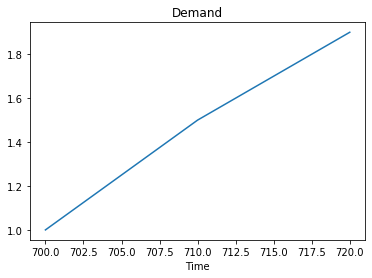

In [133]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

The demand is taken from the tutorial:

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)


In [134]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

In [135]:
scenario.add_par("demand", light_demand)

In order to define the input and output commodites of each technology, some common keys are defined.

In [136]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [137]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0)
scenario.add_par('input', bulb_in)

Because the grid has transmission losses, only 90% of the input electricity is available as output.

In [138]:
grid_efficiency = 0.9
grid_out = make_df(base_output, technology='grid', commodity='electricity', 
                   level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',
                  level='secondary', value=1.0)
scenario.add_par('input', grid_in)

In- and Output of the new gas plant is added. (The model does not include the fossil resources used as `input` for coal plants; however, costs of coal extraction are included in the parameter $variable\_cost$.)

In [139]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', coal_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', wind_out)

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity',
                  level='secondary', value=1.)
scenario.add_par('output', gas_out)

### Operational constraints

Alike coal the `capacity_factor` for gas is set to 1 as it is assumed that all installed capacity can be active at all time.

In [140]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [141]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'gas_ppl': 1,
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

The `technical_lifetime` for a gas plant is added. The technical lifetime of a gas power plant is assumed to be 30 yrs. This information is taken from the [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4). 

In [142]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [143]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'gas_ppl': 30,
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

### Technological Diffusion and Contraction

Alike in the tutorial all technologies (incl. Gas) are limited in their ability to grow. The constraint is set at 10% per year.

In [144]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [145]:
growth_technologies = [
    "coal_ppl", 
    "wind_ppl",
    "gas_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scenario.add_par('growth_activity_up', df)

## Part 1b - Defining Energy Mix 

In the following part the energy mix is defined. For this model the a mix of 40% Wind (same as tutorial), 40% coal and 20% gas was chosen.

In [146]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.4

In [147]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [148]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': 0.4 * historic_generation,
    'gas_ppl': 0.2 * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In [149]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 3, # 30 year lifetime!
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

## Part 1c - Adding costs (Objective Function)

For the following cost parameters it is assumed that the gas plants run using combined-cycle gas turbines (CCGT). The reagarding costs are again taken from the [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4). 


The interest rate parameter is kept the same.

In [150]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit='-')

### Investment Costs

The investment costs are assumed to be 1100 $/kW  ([IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4))


In [151]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [152]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'gas_ppl': 1100,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

The fixes O&M costs are assumed to be 44 $/kW/a ([IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4))

In [153]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [154]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'coal_ppl': 30,
    'gas_ppl': 44,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

[IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) only states fixed and variable costs being 44 $/kW/a. Therefore 44 $/kWa is used as variable O&M costs even this doesn't match the units of the tutorial. 

In [155]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [156]:
costs = {
    'coal_ppl': 30,
    'gas_ppl': 44,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario.add_par('var_cost', df)

### Solving the Model

In [157]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))

scenario.commit(comment='basic model of Westeros electrification')

log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 17


In [158]:
scenario.set_as_default()

In [159]:
scenario.solve()

In [160]:
scenario.var('OBJ')['lvl']

251027.28125

## Plotting Results

We make use of some custom code for plotting the results; see `tools.py` in the tutorial directory.

In [161]:
from tools import Plots
p = Plots(scenario, country, firstyear=model_horizon[0])

### Activity

How much energy is generated in each time period from the different potential sources?

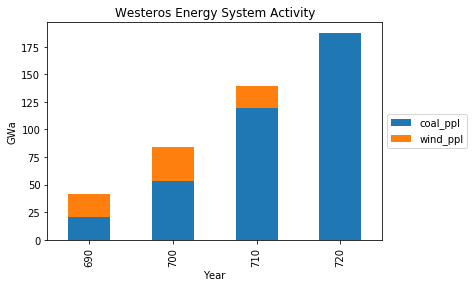

In [162]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

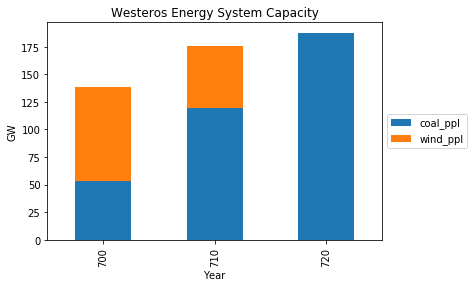

In [163]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution.
They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of
electricity), which is in fact the marginal cost of the most expensive operating generator.  

Note the price drop when the most expensive technology is no longer in the system.

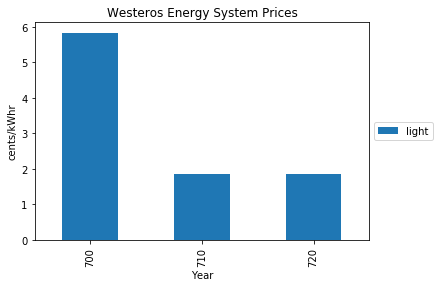

In [164]:
p.plot_prices(subset=['light'], baseyear=True)

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [165]:
mp.close_db()

## Congratulations! 

You have built and run your very first *MESSAGEix* model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github https://github.com/iiasa/message_ix  
and get in touch with us online https://groups.google.com/forum/message-ix ...